In [ ]:
!pip install stable-baselines3[extra]
#!pip install stable-baselines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 5.4 MB/s 
     |████████████████████████████████| 1.5 MB 35.6 MB/s 
     |████████████████████████████████| 1.6 MB 47.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616825 sha256=855c5a46186cc222884ea62519f572830370eae1c109cf36eb116a8671c70971
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=acab4d3cf3954434505a77076fb7f151484fb6c9adbfe6e654fe85d430794dc7
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built gym AutoROM.accept-rom-license


In [ ]:
import gym
import numpy as np

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3 import DDPG
#from stable_baselines import TRPO

In [ ]:
#from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3.ddpg.policies import MlpPolicy

In [ ]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import numpy as np
import matplotlib.pyplot as plt
!pip install odeintw
from odeintw import odeintw

class PassageEnv(Env):
    def __init__(self):
        # Limites y espacio de las acciones [omega1, omega2, omega3]
        self.action_space = Box(low=np.array([0,0,0]), high=np.array([1,1,1]))
        #  Limites y espacio de los estados: [\rho, omega1, omega2, omega3]

        """ rho = [ [0,0,0,0,0,0,0],       rho_max = [ [1,1,1,1,1,1,1],       omega_min = [0,0,0]
                    [0,0,0,0,0,0,0],                   [1,1,1,1,1,1,1],       omega_max = [1,1,1]
                    [0,0,0,0,0,0,0],                   [1,1,1,1,1,1,1],
                    [0,0,0,0,0,0,0],                   [1,1,1,1,1,1,1],
                    [0,0,0,0,0,0,0],                   [1,1,1,1,1,1,1],
                    [0,0,0,0,0,0,0],                   [1,1,1,1,1,1,1],
                    [0,0,0,0,0,0,0]]                   [1,1,1,1,1,1,1]]                 """

        self.observation_space = Box(low=np.array([0,0,0,0,0,0,0,
                                                   0,0,0,0,0,0,0,
                                                   0,0,0,0,0,0,0,
                                                   0,0,0,0,0,0,0, 
                                                   0,0,0,0,0,0,0,
                                                   0,0,0,0,0,0,0,
                                                   0,0,0,0,0,0,0,  0,0,0]), 
                                     
                                high=np.array([1,1,1,1,1,1,1,
                                               1,1,1,1,1,1,1,
                                               1,1,1,1,1,1,1,
                                               1,1,1,1,1,1,1,
                                               1,1,1,1,1,1,1,
                                               1,1,1,1,1,1,1,
                                               1,1,1,1,1,1,1,  1,1,1]))
        # Set start state
        self.state = np.array([1,0,0,0,0,0,0,
                               0,0,0,0,0,0,0,
                               0,0,0,0,0,0,0,
                               0,0,0,0,0,0,0, 
                               0,0,0,0,0,0,0, 
                               0,0,0,0,0,0,0,
                               0,0,0,0,0,0,0, 0,0,0],dtype=np.complex128)

        self.length_trial = 0


    def refuerzo(self, p7, p2, p3, p4, p5, p6):
        return (-100 + 15*np.exp(2*p7) - p2 - p3 - p4 - p5 - p6) -2*np.exp(6*p2)-2*np.exp(6*p3)-2*np.exp(6*p4)-2*np.exp(6*p5)-2*np.exp(6*p6)

    def step(self, action):
        # Aplicar accion
        omega1 = action[0]
        omega2 = action[1]
        omega3 = action[2]

        # Cambiar el hamiltoniano
        def right_part(rho, t):
  
          hamiltonian = np.array([[    0    ,  -omega1 ,    0    ,    0    ,    0    ,    0    ,    0    ],
                                  [ -omega1 ,     0    , -omega3 ,    0    ,    0    ,    0    ,    0    ],
                                  [    0    ,  -omega3 ,    0    , -omega3 ,    0    ,    0    ,    0    ],
                                  [    0    ,     0    , -omega3 ,    0    , -omega3 ,    0    ,    0    ],
                                  [    0    ,     0    ,    0    , -omega3 ,    0    , -omega3 ,    0    ],
                                  [    0    ,     0    ,    0    ,    0    , -omega3 ,    0    , -omega2 ],
                                  [    0    ,     0    ,    0    ,    0    ,    0    , -omega2 ,    0    ]],
                                  dtype=np.complex128)
          return (np.dot(hamiltonian, rho) - np.dot(rho, hamiltonian)) / (1j)

        # Evolucion temporal
        N = 100
        omegamax = 1
        dt = (50*np.pi/omegamax)/N
        #tmax = 10
        tpasos = np.linspace(0,dt,N)
        rho = np.array([[self.state[i] for i in range(0,7)],
                        [self.state[i] for i in range(7,14)],
                        [self.state[i] for i in range(14,21)],
                        [self.state[i] for i in range(21,28)],
                        [self.state[i] for i in range(28,35)],
                        [self.state[i] for i in range(35,42)],
                        [self.state[i] for i in range(42,49)]], dtype=np.complex128)

        result = odeintw(right_part, rho, tpasos)
        final_result = result[-1]
        final_result = np.reshape(final_result,(49,))

        # Nuevo estado a partir de la matriz densidad obtenida
        result = final_result
        self.state = np.array([result[0], result[1], result[2], result[3], result[4],result[5],result[6],
                               result[7], result[8], result[9], result[10], result[11],result[12],result[13],
                               result[14], result[15], result[16], result[17], result[18],result[19],result[20],
                               result[21], result[22], result[23], result[24], result[25],result[26],result[27],
                               result[28], result[29], result[30], result[31], result[32],result[33],result[34],
                               result[35], result[36], result[37], result[38], result[39],result[40],result[41],
                               result[42], result[43], result[44], result[45], result[46],result[47],result[48], 
                               omega1, omega2,omega3])

        done =False

        # Calcular el refuerzo
        reward = self.refuerzo(self.state[48], self.state[8], self.state[16], self.state[24], self.state[32],self.state[40])

      
        if self.state[8]>0.05 or self.state[16]>0.05  or self.state[24]>0.05 or self.state[32]>0.05 or self.state[40]>0.05 :
          reward -= 20

        self.length_trial += 1
      
        if self.state[48] >= 0.98 and self.length_trial ==100:
            reward +=1000
            done = True


        if self.length_trial >= 100:
            done = True


        info = {}

        return self.state, reward, done, info

    def render(self):
        pass

    def reset(self):
        self.state = np.array([1,0,0,0,0,0,0,
                               0,0,0,0,0,0,0,
                               0,0,0,0,0,0,0,
                               0,0,0,0,0,0,0, 
                               0,0,0,0,0,0,0, 
                               0,0,0,0,0,0,0,
                               0,0,0,0,0,0,0, 0,0,0],dtype=np.complex128)
        self.length_trial = 0
        return self.state


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#env = gym.make('CartPole-v1')
env = PassageEnv()

#model = PPO(MlpPolicy, env, verbose=0)
model = DDPG(MlpPolicy, env)

/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


In [ ]:
def evaluate(model, num_episodes=100):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    env = model.get_env()
    all_episode_rewards = []
    for i in range(num_episodes):
        episode_rewards = []
        done = False
        obs = env.reset()
        while not done:
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return mean_episode_reward

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

In [ ]:
import time as tiempo

inicio = tiempo.time()

# Train the agent for 10000 steps
N_steps = 120
model.learn(total_timesteps=N_steps)

fin = tiempo.time()

print("Tiempo de ejecución = ", fin-inicio)

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  self.buf_obs[key][env_idx] = obs
/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  self.actions[env_idx]
/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/off_policy_algorithm.py:502: ComplexWarning: Casting complex values to real discards the imaginary part
  next_obs[i] = infos[i]["terminal_observation"]


Tiempo de ejecución =  1.5052719116210938


In [ ]:
# Evaluate the trained agent
#mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)
#mean_reward_before_train = evaluate(model, num_episodes=100)

#print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

In [ ]:
# Leyendo archivos desde Google drive
GOOGLE_DRIVE = '/content/google_drive'
import numpy as np
from google.colab import drive
drive.mount(GOOGLE_DRIVE)
path = GOOGLE_DRIVE+'/MyDrive/archivos_teorica/'
import os.path
import os

dir_path = path+'BL_7puntos_2_'+str(N_steps)+'/'

isExist = os.path.exists(dir_path)

if not isExist:
  os.makedirs(dir_path)

path_file = dir_path+"Baselines_Model_W_"+str(N_steps)+"_episodes"
file_exists = os.path.exists(path_file+'.zip')
print(file_exists)

if not file_exists:
  model.save(path_file)

Mounted at /content/google_drive
False


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  self.buf_obs[key][env_idx] = obs
/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  self.actions[env_idx]


acciones


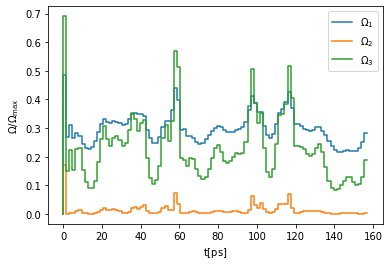

estado


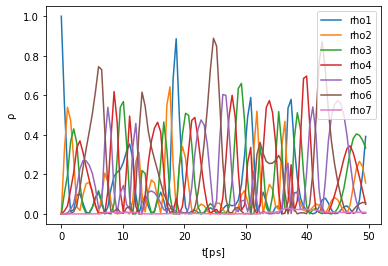

reward


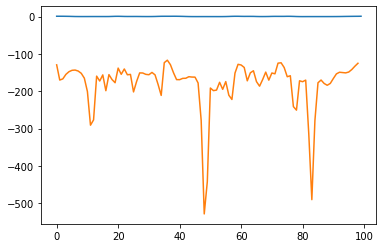

In [ ]:
env = model.get_env()
episode_rewards = []
done = False
obs = env.reset()
actions = []
p1, p2, p3, p4, p5, p6, p7 = [obs[0][0]], [obs[0][8]], [obs[0][16]], [obs[0][24]], [obs[0][32]], [obs[0][40]], [obs[0][48]]
actions.append([[0,0,0]])
obs, reward, done, info = env.step(actions[0])
while not done:
    # _states are only useful when using LSTM policies
    action, _states = model.predict(obs)
    actions.append(action)
    # here, action, rewards and dones are arrays
    # because we are using vectorized env
    obs, reward, done, info = env.step(action)
    p1.append(obs[0][0])
    p2.append(obs[0][8])
    p3.append(obs[0][16])
    p4.append(obs[0][24])
    p5.append(obs[0][32])
    p6.append(obs[0][40])
    p7.append(obs[0][48])
    episode_rewards.append(reward)
actions = np.array(actions)
actions.shape

N = len(actions[:,0,0])
tmax = 50*np.pi
tpasos = np.linspace(0,tmax,N)
print('acciones')
plt.xlabel('t[$\mathregular{ps}$]')
plt.ylabel('$\mathregular{\Omega/\Omega_{max}}$')
plt.step(tpasos, actions[:,0,0],label='$\mathregular{\Omega_{1}}$')
plt.step(tpasos, actions[:,0,1],label='$\mathregular{\Omega_{2}}$')
plt.step(tpasos, actions[:,0,2],label='$\mathregular{\Omega_{3}}$')
plt.legend()
path_img = dir_path+'Acciones.png'
file_exists = os.path.exists(path_img)
if not file_exists:
  plt.savefig(dir_path+'Acciones.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()
print('estado')
plt.plot(tpasos[:-1]/(np.pi), p1[:-1], label='rho1')
plt.plot(tpasos[:-1]/(np.pi), p2[:-1], label='rho2')
plt.plot(tpasos[:-1]/(np.pi),p3[:-1], label='rho3')
plt.plot(tpasos[:-1]/(np.pi),p4[:-1], label='rho4')
plt.plot(tpasos[:-1]/(np.pi), p5[:-1], label='rho5')
plt.plot(tpasos[:-1]/(np.pi),p6[:-1], label='rho6')
plt.plot(tpasos[:-1]/(np.pi), p7[:-1], label='rho7')
plt.legend()
plt.xlabel('t[$\mathregular{ps}$]')
plt.ylabel('$\mathregular{\\rho}$')

path_img = dir_path+'Estado.png'
file_exists = os.path.exists(path_img)
if not file_exists:
  plt.savefig(dir_path+'Estado.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()
ptot = np.array(p1)+np.array(p2)+np.array(p3)
plt.plot(ptot)
print('reward')
plt.plot(episode_rewards)
plt.show()